## 线性支持向量机：软边距（soft-margin）
---

本节讲述如何使用 tensorflow 创建软边距 svm。

我们使用 iris 数据，指定：

- x1 = Sepal Length；
- x2 = Petal Width；
- Class: 1 = setosa；
- Class: -1 = 非 setosa；

这里我们知道对于 I.setosa 分类 x 和 y 是线性可分的。

注意，对点集我们实现了可允许误差范围的软边距。错误项的边际由下面的“alpha”给出。要表现得像一个硬边距SVM，设置alpha = 0.（在 notebook 代码块＃7）

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

### 启动计算图

In [2]:
sess = tf.Session()

### 加载数据

In [3]:
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])

### 分解成训练/测试数据

In [4]:
train_indices = np.random.choice(len(x_vals),
                                 round(len(x_vals)*0.8),
                                 replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

### 设置模型参数，占位符和系数

In [5]:
# Declare batch size
batch_size = 100

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Create variables for SVM
A = tf.Variable(tf.random_normal(shape=[2, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

### 声明模型和 L2 Norm

SVM 线性模型由以下公式给出：

$$\left[ \frac{1}{n}\sum_{i=1}^{n}\max(0, 1-A\cdot x - b)\right] + \alpha \cdot \|A\|^2$$

我们的损失函数将是上述公式的产出，我们使用 tensirflow 来最小化它。注意 $n$ 是点集数量（批量）。$A$是超平面法线向量（要求解的），$b$ 是超平面偏移量（要求解的），$\alpha$ 是软边距参数。

In [6]:
# Declare model operations
model_output = tf.subtract(tf.matmul(x_data, A), b)

# Declare vector L2 'Norm' function squared
l2_norm = tf.reduce_sum(tf.square(A))

在这里，我们基于点的分类（它们所在的哪一侧）制作特定的损失函数。

此外，请注意，alpha 是软边距的 term 并可增加以允许更多错误冗余的分类点。对于硬边距，设置 alpha = 0。

In [7]:
# Declare loss function
# Loss = max(0, 1-pred*actual) + alpha * L2_norm(A)^2
# L2 regularization parameter, alpha
alpha = tf.constant([0.01])
# Margin term in loss
classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(model_output, y_target))))
# Put terms together
loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))

创建预测函数，优化函数和初始化变量

In [8]:
# Declare prediction function
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target), tf.float32))

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

好了，开始训练

In [9]:
# Traning loop
loss_vec = []
train_accuracy = []
test_accuracy = []
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    train_acc_temp = sess.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_accuracy.append(train_acc_temp)
    
    test_acc_temp = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_accuracy.append(test_acc_temp)
    
    if (i+1) % 100 == 0:
        print('Step #{} A = {}, b = {}'.format(
            str(i+1),
            str(sess.run(A)),
            str(sess.run(b))
        ))
        print('Loss = ' + str(temp_loss))

Step #100 A = [[-0.08281014]
 [-0.37535754]], b = [[-0.09000054]]
Loss = [ 0.54207027]
Step #200 A = [[-0.03858841]
 [-0.64415771]], b = [[-0.14760052]]
Loss = [ 0.36989316]
Step #300 A = [[ 0.02083039]
 [-0.90015209]], b = [[-0.21140052]]
Loss = [ 0.38996497]
Step #400 A = [[ 0.07397948]
 [-1.14489543]], b = [[-0.2726005]]
Loss = [ 0.2379836]
Step #500 A = [[ 0.11402685]
 [-1.39008963]], b = [[-0.33520052]]
Loss = [ 0.21116135]


现在提取线性系数和获取 SVM 边界线。

In [10]:
# Extract coefficients
[[a1], [a2]] = sess.run(A)
[[b]] = sess.run(b)
slope = -a2 / a1
y_intercept = b / a1

# Extract x1 and x2 vals
x1_vals = [d[1] for d in x_vals]

# Get best fit line
best_fit = []
for i in x1_vals:
    best_fit.append(slope*i+y_intercept)

# Separate I. setosa
setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == 1]
setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == 1]
not_setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == -1]
not_setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == -1]

matplotlib 代码画图

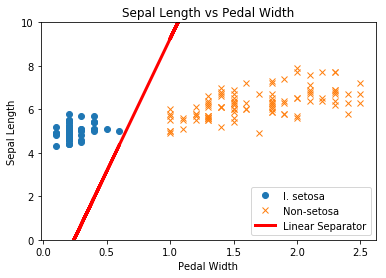

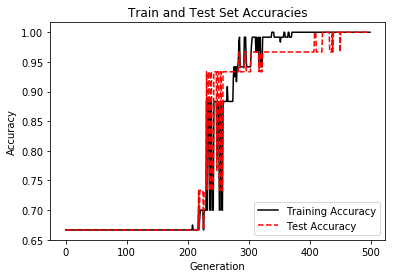

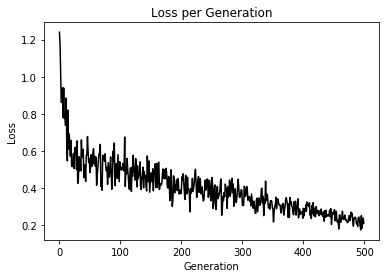

In [11]:
%matplotlib inline
# Plot data and line
plt.plot(setosa_x, setosa_y, 'o', label='I. setosa')
plt.plot(not_setosa_x, not_setosa_y, 'x', label='Non-setosa')
plt.plot(x1_vals, best_fit, 'r-', label='Linear Separator', linewidth=3)
plt.ylim([0, 10])
plt.legend(loc='lower right')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot train/test accuracies
plt.plot(train_accuracy, 'k-', label='Training Accuracy')
plt.plot(test_accuracy, 'r--', label='Test Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()